<a href="https://colab.research.google.com/github/MichaelDeng03/GenAI_Agents/blob/main/all_agents_tutorials/art_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Art Agent
This tutorial will walk through the creation of an AI Agent that helps you explore and learn art!

### Overview
For knowledge retrieval, this tutorial uses [LightRAG](https://github.com/HKUDS/LightRAG) which is knowledge graph based RAG implementation. Compared to GraphRAG, LightRAG is more accurate for single topic datasets, and uses 1,000x less tokens for retrieval. Furthermore, documents can be added to LightRAG incrementally without rebuilding the knowledge graph. See the full results in the [paper](https://arxiv.org/abs/2410.05779).

For the agent itself, we use LangGraph.

### Outline
0. [Setup](#setup)
1. [Data Preparation + RAG](#data-preparation--rag)
2. [Agent Creation](#agent-creation)
3. [Final App](#final-app)

### Setup

#### Environment

This tutorial uses openai embedding models. While there are alternatives, we recommend using the openai models for the best results.

In [ ]:
!uv venv
!uv pip install lightrag-hku aioboto3 numpy ollama openai tenacity aioboto3 transformers torch tiktoken nano_vectordb neo4j oracledb textract setuptools pyvis sqlalchemy langchain_community langchain_openai sqlmodel ipywidgets==7.7.1 asyncio markdown langgraph -q

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = ...

In [ ]:
import ipywidgets as widgets

import random
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod

from IPython.display import display, Image as IPImage


from io import BytesIO
from PIL import Image as PILImage

import markdown

import requests
from PIL import Image as PILImage
from ipywidgets import widgets
import markdown
import json

### Data Preparation + RAG

#### Data Preparation

We scraped data from [wikiart](https://wikiart.org/) using a combination of requests and beautiful soup.

We provide a preprocessed, limited dataset of this data for the tutorial found in `data/artinfo.json`.

Preprocessed data for each artwork looks like:

```plaintext
Artwork Name: {artwork_name}
Artwork Genre: {genre_list}
Artwork Media: {media_list}
Wikiart URL: https://www.wikiart.org{wikiart_slug}

Wikipedia Article:
{wiki_article}
```


In [4]:
artwork_info = None
with open('./data/artinfo.json', 'r') as f:
    artwork_info = json.load(f)['info']
print(len(artwork_info))
print(artwork_info[0])

78

Artist: Frederick McCubbin
Artwork Name: Down on his luck
Artwork Genre: genre painting
Artwork Media: canvas,oil
Wikiart URL: https://www.wikiart.org/en/frederick-mccubbin/down-on-his-luck-1889

Wikipedia Article:
 The painting was owned by William Fergusson up to 1986 until it was purchased by the Art Gallery of Western Australia in Perth.



#### LightRAG

RAG systems enhance LLMs by integrating external knowledge sources. Traditional RAG solutions assume a 'flat' data representation, which can fail to capture complex dependencies. 
We use a hierarchical representation a knowledge graph to model our inherently hierarchical artwork data. 

LightRAG incorporates graph structures into indexing and retrieval. It creates a knowledge graph encoding 'entities' and their relationships, using techniques such as entity recognition, relation extration, and graph embeding models. It's dual-level retrieval system is perfect for our Artwork dataset. Fine grained details like artist names, artwork titles, and their references are retrieved via low-level concepts, and thematic information is retrieved via high-level concepts.


In [5]:
from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam

import nest_asyncio

nest_asyncio.apply()
WORKING_DIR = "./data"
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete,
)

In [6]:
# Un-comment to index the data
# import time

# # Create the RAG database
# batch_size = 30

# # Loop through the list in batches of 30 to avoid rate limits
# for i in range(0, len(artwork_info), 30):
#     batch = artwork_info[i : i + batch_size]
#     rag.insert(batch)
#     time.sleep(15)

### Agent Chain Creation

Here we create a chain of functions to aid with retrieval of artwork information.
Some of the following functions are helper functions, while others are core to the chain's functionality.

In [ ]:
# Helper Functions


def get_artwork_image_url(url: str):
    """
    Gets an artwork image from its URL.
    """
    import requests
    from bs4 import BeautifulSoup as bs

    response = requests.get(url)
    soup = bs(response.text, "html.parser")
    img = soup.find("img", {"itemprop": "image"})

    return img.get("src")


def image_widget_value(artwork_url: str):
    image_url = get_artwork_image_url(artwork_url)
    resp = requests.get(image_url)
    if resp.status_code == 200:
        image = PILImage.open(BytesIO(resp.content))
        width, height = image.size
    else:
        return 'No image found'

    return f'<img src={image_url} style="width:{width}px;height:{height}px;">'


def html_widget_value(description: str):
    style = (
        "display: inline-block; "
        "width: fit-content; "
        "max-width: 100%; "  # Optional to prevent excessive width
        "padding: 5px; "
        "font-size: 16px; "
        "line-height: 1.5; "
        "border: 1px solid #ccc; "  # Optional, for visibility
        "border-radius: 5px; "
        "background-color: #f9f9f9;"
    )
    return f'<div style="{style}">{markdown.markdown(description)}</div>'

#### State Management
In order to keep track of the state of the art tour, we create an object that contains the current artwork, its data, past artworks, a history of this tour's discussion, and a request for a specific artwork or category:

In [9]:
class ArtTourState(TypedDict):
    artwork: str
    artwork_metadata: str
    artwork_description: str
    artwork_url: str
    art_request: str
    past_artworks: list[str]
    discussion_messages: list[str]
    app_message: str  # intro and conclusion
    exit: bool

    footer: widgets.HTML
    header: widgets.HTML
    image: widgets.HTML

## Chain Node Functions
We define helper functions consuming state that modify the widgets, and call upon the RAG database to retrieve information.
Some of these functions include:
- getters for current artwork data
- random artwork retrieval
- display artwork

In [10]:
def get_artwork_url_from_name(state: ArtTourState):
    artwork_name = state['artwork']
    prompt = f"""
    What is the Wikiart URL for this artwork: {artwork_name}

    Return only the wikiart url in plain text. Do not include any other text. URL only.
    """
    return {"artwork_url": rag.query(prompt, param=QueryParam(mode="hybrid"))}

In [11]:
def describe_artwork(state: ArtTourState):
    artwork = state['artwork']
    metadata = rag.query(
        f"""What is the genre, media, and style of the following artwork: {artwork}.
    Return the description in the following format:
    artwork name: <artwork name>
    artist: <artist>
    genre: <genre>
    media: <media>
    style: <style>

    Return this information and nothing else.
    """,
        param=QueryParam(mode="hybrid"),
    )

    dense_description = str(
        rag.query(
            f"Describe the imagery and context of {artwork} in 2 concise paragraphs.", param=QueryParam(mode="hybrid")
        )
    )

    return {
        "artwork_metadata": metadata,
        "artwork_description": dense_description,
        **get_artwork_url_from_name(state),
    }

In [12]:
def request_artwork(state: ArtTourState):
    description = state['art_request']
    prompt = f"""
    The user has requested the following for their next artwork. Choose a related artwork.
    {description}

    Return the name of the artwork and nothing else.
    """
    return {"artwork": rag.query(prompt, param=QueryParam(mode="hybrid"))}


def get_next_artwork(state: ArtTourState):
    prev_artwork = state['artwork_metadata']
    next_artwork = state['art_request']
    past_artworks = state['past_artworks']
    prompt = f"""You are an art tour guide.
    The have discussed these artworks earlier in the tour: {past_artworks}
    You just discussed this artwork:
    {prev_artwork}

    The user has requested the following for their next artwork. Choose a related artwork.
    {next_artwork}

    Return the name of the artwork and nothing else.
    """
    next_artwork = rag.query(prompt, param=QueryParam(mode="hybrid"))
    art_data = describe_artwork({'artwork': next_artwork})
    out = {
        "artwork": next_artwork,
        "past_artworks": past_artworks + [prev_artwork],
        **art_data,  # metadata + description
    }
    out.update(art_data)
    return out

In [ ]:
with open('./data/artinfo.json', 'r') as f:
    art_json = json.load(f)
artworks = [art_info.split('\n')[2].split(': ')[1] for art_info in art_json['info']]
print("Number of artworks indexed:", len(artworks))


def get_random_art():
    out = {"artwork": random.sample(artworks, 1)[0]}
    art_data = describe_artwork(out)
    out.update(art_data)
    return out

Number of artworks indexed: 78


In [ ]:
tour_instructions = """
You will be shown an artwork and a description.
Take a close look and articulate what you see, think, and feel.
Afterwards, you may describe an area of interest to continue exploring or view a new random artwork.
At the end, you'll be give a list of all the artworks you've seen.
"""


def tour_introduction(state: ArtTourState):
    out = get_random_art()
    out['app_message'] = tour_instructions
    return out


def conclude_tour(state: ArtTourState):
    summary = str(
        rag.query(
            f"""
            Build a narrative and summarize the themes of an art tour you just gave with these artworks
            {[state['artwork_metadata']] + state['past_artworks']}
            Start by writing a short introduction.
            Write no more than 2 sentences about any particular artwork.
            End by writing a short conclusion.
            Thank the user for their engagement.
            """,
            param=QueryParam(mode="hybrid"),
        )
    )

    tour_conclusion = f"""
    Thank you for doing a tour!
    These are the artworks you viewed:
    {", ".join(state['past_artworks'])}

    Here's a summary of the themes:
    {summary}
    """
    state['header'].value = html_widget_value("Art Tour Completed")
    state['image'].value = html_widget_value(summary)
    state['footer'].value = html_widget_value("Thank you")
    return {'app_message': tour_conclusion}


def display_artwork(state: ArtTourState):
    """
    Render the widgets
    """
    state['footer'].value = html_widget_value(state['artwork_description'] + "\n\n## Comment on the artwork.")
    state['header'].value = html_widget_value(state['artwork'])
    state['image'].value = image_widget_value(state['artwork_url'])

    return state


def choose_next_artwork(state: ArtTourState):
    return get_next_artwork(state)


def discuss(state: ArtTourState):
    """
    Discuss the artwork with the user
    """
    while True:
        # Capture user message
        user_input = input("type `next` or `exit` or a comment to discuss\n")

        if user_input == 'next':
            state['art_request'] = input("Give a description of what'd you'd like to see next.")
            return {'art_request': state['art_request']}
        if user_input == 'exit':
            state['exit'] = True
            return state

        # Dicuss with the user
        summary = str(
            rag.query(
                f"""
                The user has said:
                {user_input}
                about the artwork:
                {state['artwork']}

                Respond with 1-2 sentences enriching the user with new facts or feedback.
                """,
                param=QueryParam(mode="hybrid"),
            )
        )
        state['header'].value = html_widget_value(f"{state['artwork']} Discussion")
        state['footer'].value = html_widget_value(
            f"{state['artwork_description']} \n## Tour Guide Response:\n {summary}"
        )

## Final App Loop
Finally, we create the visualizations for the art tour and wrap the tour flow in a while loop to complete the decision cycle:

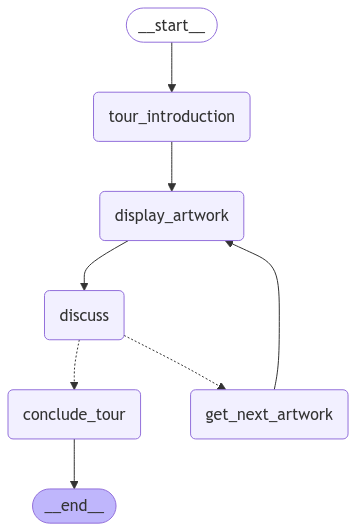

In [22]:
from typing import Literal


workflow = StateGraph(ArtTourState)
# nodes
workflow.add_node('tour_introduction', tour_introduction)
workflow.add_node('display_artwork', display_artwork)
workflow.add_node('get_next_artwork', get_next_artwork)

workflow.add_node('discuss', discuss)
workflow.add_node('conclude_tour', conclude_tour)

workflow.add_edge('tour_introduction', 'display_artwork')
workflow.add_edge('display_artwork', 'discuss')

workflow.add_edge('get_next_artwork', 'display_artwork')
workflow.add_edge('conclude_tour', END)


def conclude_or_moreart(state: ArtTourState) -> Literal['conclude_tour', 'get_next_artwork']:
    if state.get('exit'):
        return 'conclude_tour'
    return 'get_next_artwork'


workflow.add_conditional_edges('discuss', conclude_or_moreart)

workflow.set_entry_point('tour_introduction')
app = workflow.compile()
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
header = widgets.HTML(value=html_widget_value("Welcome to the Art Tour!"))
image = widgets.HTML(value="")
footer = widgets.HTML(value="")
display(widgets.VBox([header, image, footer]))
app.invoke(
    {"artwork": None, "past_artworks": [], 'header': header, 'image': image, 'footer': footer, 'art_request': None}
)

[chain/start] [chain:LangGraph] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:tour_introduction] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:tour_introduction > chain:ChannelWrite<tour_introduction,artwork,artwork_metadata,artwork_description,artwork_url,art_request,past_artworks,discussion_messages,app_message,exit,footer,header,image>] Entering Chain run with input:
{
  "artwork": "Boulevard Montmartre Spring",
  "artwork_metadata": "```markdown\nartwork name: Boulevard Montmartre Spring  \nartist: Camille Pissarro  \ngenre: cityscape  \nmedia: canvas, oil  \nstyle: Impressionism  \n```",
  "artwork_description": "**Imagery of Boulevard Montmartre Spring**\n\nBoulevard Montmartre Spring is an oil painting created in 1897 by Pierre-Auguste

{'artwork': '**A Balcony in Paris**',
 'artwork_metadata': '```markdown\nartwork name: A Balcony in Paris  \nartist: Gustave Caillebotte  \ngenre: cityscape  \nmedia: canvas, oil  \nstyle: Impressionism  \n```',
 'artwork_description': "**A Balcony in Paris**, created by Gustave Caillebotte around 1880-81, captures the essence of urban Parisian life through a unique perspective. The painting depicts a view from a balcony overlooking an urban street, framed by an ornate iron grill that adds depth and complexity to the composition. This imagery not only highlights the bustling life below but also provides a physical barrier that separates the interior of the bourgeois home from the vibrant streets of Paris. The careful arrangement of elements in the foreground and the distant street scene create a visual narrative that invites viewers to ponder the contrast between private and public spaces.\n\nThe artwork is executed in oil on canvas, exemplifying the characteristics of the Impressionis